### A Comparative Study of Transformer Models for Sarcasm Detection
#### Pranav Parthasarathy

School of Engineering and Applied Sciences

George Washington University

Importing necessary libraries

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from transformers import ElectraForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from transformers import Trainer

import warnings
warnings.filterwarnings("ignore")


Loading JSON Dataset

In [3]:
# Load your JSON dataset
file_path = "Sarcasm_Headlines_Dataset.json"
df = pd.read_json(file_path,lines=True)

# Check if the data loaded correctly
print(df.head())


                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


Splitting Data into Training and Testing Sets

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Renaming Columns and Dropping Unnecessary Columns

In [5]:
train_df = train_df.rename(columns={"is_sarcastic": "label", "headline": "text"})
test_df = test_df.rename(columns={"is_sarcastic": "label", "headline": "text"})

In [6]:
train_df.drop(columns=["article_link"], inplace=True)

Creating Dataset Objects

In [7]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

### MiniLM

Loading Tokenizer and Model

In [8]:
#Load tokenizer and model
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining Tokenization Function and Tokenizing data

In [ ]:
#Tokenize
def tokenize(batch):
    """ Tokenizes the input text using the specified tokenizer.
    Args:
        batch (dict): A dictionary containing the input text.
    Returns:
        dict: A dictionary containing the tokenized input text.
    """
    return tokenizer(batch["text"], padding=True, truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/21367 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5342 [00:00<?, ? examples/s]

Removing Unnecessary Columns and Converting to Torch Format

In [10]:
train_ds = train_ds.remove_columns(["text", "__index_level_0__"])
test_ds = test_ds.remove_columns(["text", "__index_level_0__"])

train_ds.set_format("torch")
test_ds.set_format("torch")

Defining Function to Load the pre-trained MiniLM Model

In [ ]:
# Load the pre-trained model
def load_model_from_pkl(filename="MiniLM.pkl"):
    """ Loads a pre-trained model and tokenizer from a .pkl file.
    Args:
        filename (str): The name of the .pkl file to load.
    Returns:
        model: The loaded model.
        tokenizer: The loaded tokenizer.
    """
    # Load the saved object
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)
    
    # Reconstruct the tokenizer
    tokenizer = saved_data["tokenizer"]

    # Reconstruct the model using the saved configuration and load the state dict
    model = AutoModelForSequenceClassification.from_config(saved_data["model_config"])
    model.load_state_dict(saved_data["model_state_dict"])
    
    print("Model and tokenizer successfully loaded from .pkl file")
    return model, tokenizer


model, tokenizer = load_model_from_pkl("MiniLM.pkl")

Model and tokenizer successfully loaded from .pkl file


Loading Model and Tokenizer from Pickle File

In [31]:
# Load model and tokenizer
model_loaded, tokenizer_loaded = load_model_from_pkl("MiniLM.pkl")

# Create a Trainer object for evaluation or prediction
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Evaluate the model on the test dataset
eval_results = trainer_loaded.evaluate(eval_dataset=test_ds)
print("Evaluation Results:", eval_results)

# Predict using the model
predictions = trainer_loaded.predict(test_ds)

# You can get prediction labels like this:
predicted_labels = predictions.predictions.argmax(axis=-1)
print("Predicted labels:", predicted_labels)

Model and tokenizer successfully loaded from .pkl file


  0%|          | 0/668 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.31919485330581665, 'eval_model_preparation_time': 0.0, 'eval_runtime': 69.3113, 'eval_samples_per_second': 77.073, 'eval_steps_per_second': 9.638}


  0%|          | 0/668 [00:00<?, ?it/s]

Predicted labels: [1 0 0 ... 1 1 1]


Creating Trainer Object, Evaluating and Making Predictions

  0%|          | 0/668 [00:00<?, ?it/s]

Classification Report:

               precision    recall  f1-score   support

Not Sarcastic       0.94      0.96      0.95      2996
    Sarcastic       0.94      0.92      0.93      2346

     accuracy                           0.94      5342
    macro avg       0.94      0.94      0.94      5342
 weighted avg       0.94      0.94      0.94      5342



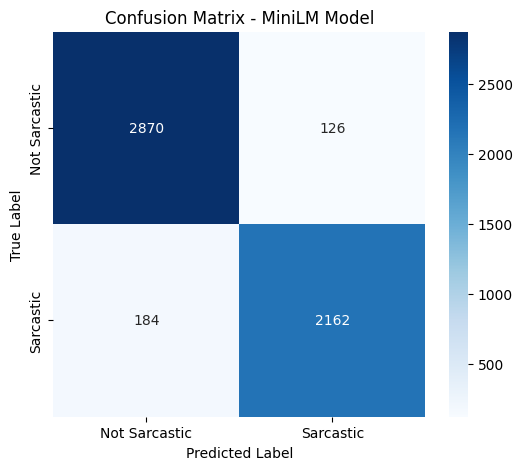

In [32]:

# Create a Trainer using the loaded model
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Get predictions
predictions = trainer_loaded.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Save and display metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not Sarcastic", "Sarcastic"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.title("Confusion Matrix - MiniLM Model")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save metrics dictionary
metrics_dict = {
    "Model": "MiniLM Model",
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-Score": f1_score(y_true, y_pred)
}

### Electra

Loading Electra Model and Tokenizer

In [14]:
# Load the dataset into a Hugging Face Dataset object

model_name = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

Defining Tokenization Function and Tokenizing data

In [ ]:
def tokenize_function(example):
    """Tokenizes the input text.
    Args:
        example (dict): A dictionary containing the text to be tokenized.
    Returns:
        dict: A dictionary containing the tokenized text.
    """
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/21367 [00:00<?, ? examples/s]

Map:   0%|          | 0/5342 [00:00<?, ? examples/s]

Loading the saved trained electra model

In [17]:

def load_model_from_pkl(filename="electra_model.pkl"):
    """
    Load a model and tokenizer from a .pkl file (saved using save_model_as_pkl).
    
    Args:
        filename (str): Path to the pickle file.
        
    Returns:
        model: Loaded model ready for inference or evaluation.
        tokenizer: Loaded tokenizer ready for text preprocessing.
    """
    # Load the saved pickle file
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Reconstruct the model (careful: instantiate from config manually)
    model = ElectraForSequenceClassification(saved_data['model_config'])
    model.load_state_dict(saved_data['model_state_dict'])

    # Load the tokenizer
    tokenizer = saved_data['tokenizer']

    print(f"Model and Tokenizer successfully loaded from {filename}")
    return model, tokenizer

model_loaded, tokenizer_loaded = load_model_from_pkl("electra_model.pkl")


Model and Tokenizer successfully loaded from electra_model.pkl


In [18]:
# Create a Trainer object if you want to evaluate or predict
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Evaluate
results = trainer_loaded.evaluate(test_ds)
print(results)

# Predict (optional)
predictions = trainer_loaded.predict(test_ds)

  0%|          | 0/668 [00:00<?, ?it/s]

{'eval_loss': 0.6967154741287231, 'eval_model_preparation_time': 0.0056, 'eval_runtime': 36.2414, 'eval_samples_per_second': 147.4, 'eval_steps_per_second': 18.432}


  0%|          | 0/668 [00:00<?, ?it/s]

Creating Trainer Object, Evaluating and Making Predictions

  0%|          | 0/668 [00:00<?, ?it/s]

Classification Report:

               precision    recall  f1-score   support

Not Sarcastic       0.91      0.95      0.93      2996
    Sarcastic       0.94      0.89      0.91      2346

     accuracy                           0.92      5342
    macro avg       0.93      0.92      0.92      5342
 weighted avg       0.92      0.92      0.92      5342



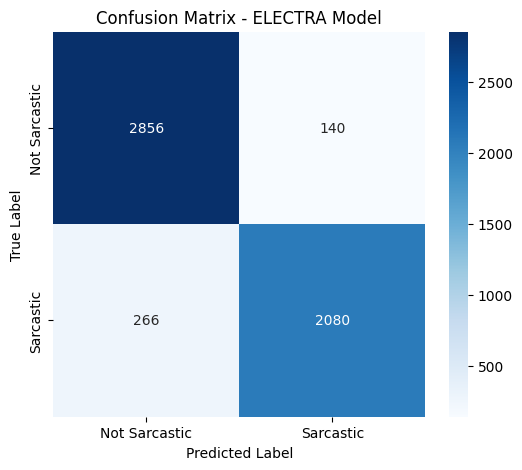

In [19]:
# Create a Trainer using the loaded model
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Get predictions
predictions = trainer_loaded.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Save and display metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not Sarcastic", "Sarcastic"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.title("Confusion Matrix - ELECTRA Model")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save metrics dictionary
metrics_dict = {
    "Model": "ELECTRA",
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-Score": f1_score(y_true, y_pred)
}

### DistilBERT

In [20]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Loading DistilBERT Model and Tokenizer

In [21]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    """ Tokenizes the input text using the specified tokenizer.
    Args:
        examples (dict): A dictionary containing the input text.
    Returns:
        dict: A dictionary containing the tokenized input text.
    """
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [23]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/21367 [00:00<?, ? examples/s]

Map:   0%|          | 0/5342 [00:00<?, ? examples/s]

In [24]:
train_dataset = train_dataset.remove_columns(["text", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

In [25]:
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Defining Function to Load the pre-trained DistilBERT Model

In [ ]:
# Save the model and tokenizer to a .pkl file
def load_model_from_pkl(filename="distilbert_sarcasm_model.pkl"):
    """ Loads a pre-trained DistilBERT model and tokenizer from a .pkl file.
    Args:
        filename (str): The name of the .pkl file to load.
    Returns:
        model: The loaded model.
        tokenizer: The loaded tokenizer.
    """
    with open(filename, "rb") as f:
        save_object = pickle.load(f)

    # Reconstruct the model from saved state and config
    model = DistilBertForSequenceClassification(config=save_object["model_config"])
    model.load_state_dict(save_object["model_state_dict"])

    tokenizer = save_object["tokenizer"]
    return model, tokenizer

# Load model and tokenizer
model_loaded, tokenizer_loaded = load_model_from_pkl("distilbert_sarcasm_model.pkl")

# Create a Trainer for evaluation or prediction
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Evaluate the model on the test dataset
eval_results = trainer_loaded.evaluate(eval_dataset=test_dataset)
print("Evaluation Results:", eval_results)

# Predict using the model
predictions = trainer_loaded.predict(test_dataset)

# Get predicted labels
predicted_labels = predictions.predictions.argmax(axis=-1)
print("Predicted labels:", predicted_labels)

  0%|          | 0/668 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.31260567903518677, 'eval_model_preparation_time': 0.0013, 'eval_runtime': 82.9428, 'eval_samples_per_second': 64.406, 'eval_steps_per_second': 8.054}


  0%|          | 0/668 [00:00<?, ?it/s]

Predicted labels: [1 0 0 ... 0 1 1]


Creating Trainer Object, Evaluating and Making Predictions

  0%|          | 0/668 [00:00<?, ?it/s]

Classification Report:

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.95      0.94      2996
    Sarcastic       0.93      0.91      0.92      2346

     accuracy                           0.93      5342
    macro avg       0.93      0.93      0.93      5342
 weighted avg       0.93      0.93      0.93      5342



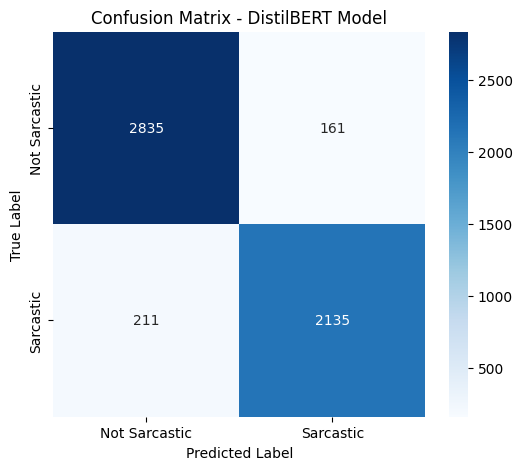

In [27]:
# Create a Trainer using the loaded DistilBERT model
trainer_loaded = Trainer(
    model=model_loaded,
    tokenizer=tokenizer_loaded
)

# Get predictions
predictions = trainer_loaded.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Save and display metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not Sarcastic", "Sarcastic"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.title("Confusion Matrix - DistilBERT Model")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save metrics dictionary
metrics_dict = {
    "Model": "DistilBERT Model",
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-Score": f1_score(y_true, y_pred)
}